<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Подбор-модели" data-toc-modified-id="Подбор-модели-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подбор модели</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from random import randint

## Подготовка данных

**Изучение данных из файла**

In [2]:
# path = '/datasets/'
path = ''
data = pd.read_csv(path+'Churn.csv', index_col=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Согласно документации к данным:

Признаки

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак

- Exited — факт ухода клиента

Столбцы 'RowNumber', 'CustomerId', 'Surname' не будут полезны для дальнейшего исследования удалим их:

In [4]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

**Вывод**

Предварительно можно утверждать, что для исследования данных достаточно:
- в исходном датафрейме три перменные типа `float`, восемь типа `int` и три типа `object`;
- в данных есть параметр `Tenure` с пропущенными значениями типа `NaN`, пропуски носят случайный характер (MAR);
- из датафрейма были удалены столбцы `'RowNumber'`, `'CustomerId'`, `'Surname'`.

**Обработка пропусков**

Сгруппируем данных по врозрасту и заменим пропуски 'Tenure' медианой соответствующей возрастной категории:

In [5]:
data.loc[data['Tenure'].isna(), 'Tenure']=randint(0,10)

**Приведение типов данных**

In [6]:
data[['Balance', 'EstimatedSalary', 'Tenure']] = data[['Balance', 'EstimatedSalary', 'Tenure']].astype('int')

**Обработка категориальных признаков методом One-Hot-Encoding** 

In [7]:
# Прямое кодирование
data = pd.get_dummies(data, drop_first=True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0,1,1,1,101348,1,0,0,0
1,608,41,1,83807,1,0,1,112542,0,0,1,0
2,502,42,8,159660,3,1,0,113931,1,0,0,0
3,699,39,1,0,2,0,0,93826,0,0,0,0
4,850,43,2,125510,1,1,1,79084,0,0,1,0


<AxesSubplot:>

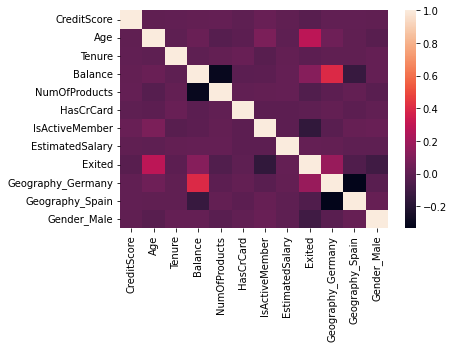

In [8]:
# Построение тепловой карты признаков
sns.heatmap(data.corr())

<div class="alert alert-block alert-info">
<b>Совет </b>  Советую обратить внимание на библиотеки sweetviz и pandas_profiling помогут в проведении более тщательного EDA анализа. Исследовательский анализ можно делать и с помощью ручного вызова функций дефолтных библиотек. Данные библиотеки хороши для максимизации комфорта презентации результатов анализа бизнес-пользователям. 
    
Очень просты в использоовании, на вход кладется датафрейм: pandas_profiling.ProfileReport(df) <br> P.S. Чтобы пробовать на платформе практикума нужно будет установить пакеты таким образом (локально проблем не будет):
    
    # библиотеки, которых нет на сервере
    !pip install sweetviz -q
    # Библиотека pandas-profiling не всегда устанавливается стабильно, поэтому принудительно задать стабильные версии
    !pip install pandas_profiling==1.4.1 -q
    !pip install pandas==0.25.3 -q
    # Обновить версию scikit-learn навсякий случай
    !pip install -U scikit-learn -q
Чтобы обычные графики не ломались важно указать `%matplotlib inline`
</div>

**Разделение датафрейма на признаки и целевой признак**

In [9]:
features = data.drop('Exited', axis=1)
target = data['Exited']

**Разделение на обучающую, тестовую и валидационную выборки**


Разделим исходный датафрейм в соотношении: 

- обучающая выборка — 60%
- тестовая выборка — 20%
- валидационная выборка — 20%

In [10]:
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)

Размеры полученных выборок:

In [11]:
# Обучающая выборка
print('train:', features_train.shape)

# Валидационная выборка
print('valid:', features_valid.shape)

# Тестовая выборка
print('test:', features_test.shape)

train: (6000, 11)
valid: (2000, 11)
test: (2000, 11)


**Масштабирование признаков**

In [12]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

# pd.options.mode.chained_assigment = None

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


**Вывод**

Целевой признак, факт ухода клиента (ушёл — 1, не ушёл — 0) это категориальный признак — решается задача классификации.

## Исследование задачи

In [13]:
# Построение Roc-кривой
def plot_roc_auc(target, probabilities_one):
    fpr, tpr, threshold = roc_curve(target, probabilities_one)
    plt.figure()

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

    return roc_auc_score(target, probabilities_one)

**Построим пробную модель:** 

- логистической регрессии

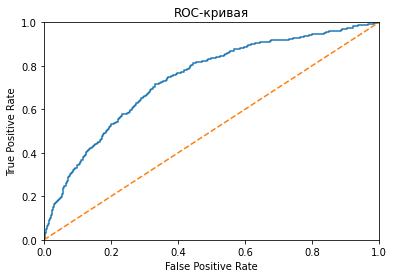

ROC_AUC 0.7386170287720497
accuracy_score: 0.791
f1_score: 0.2743055555555555


In [14]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

accuracy_valid = accuracy_score(target_valid, predicted_valid)
f1_valid = f1_score(target_valid, predicted_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = plot_roc_auc(target_valid,  probabilities_one_valid)
print("ROC_AUC", auc_roc)
print('accuracy_score:', accuracy_valid)
print('f1_score:', f1_valid)

- решающего дерева

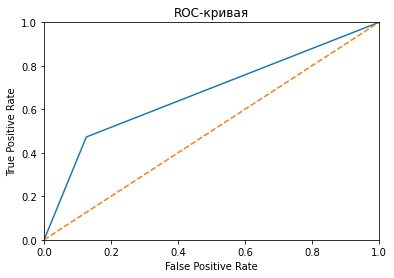

ROC_AUC 0.6733121361894011
accuracy_score: 0.789
f1_score: 0.48661800486618007


In [15]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

accuracy_valid = accuracy_score(target_valid, predicted_valid)
f1_valid = f1_score(target_valid, predicted_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = plot_roc_auc(target_valid,  probabilities_one_valid)
print("ROC_AUC", auc_roc)
print('accuracy_score:', accuracy_valid)
print('f1_score:', f1_valid)

- случайного леса

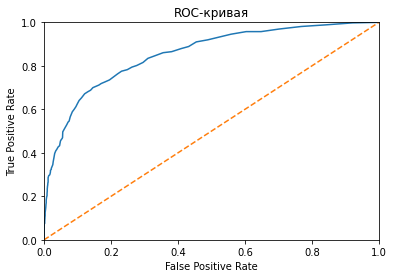

ROC_AUC 0.854069506844099
accuracy_score: 0.846
f1_score: 0.5375375375375375


In [16]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

accuracy_valid = accuracy_score(target_valid, predicted_valid)
f1_valid = f1_score(target_valid, predicted_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = plot_roc_auc(target_valid,  probabilities_one_valid)
print("ROC_AUC", auc_roc)
print('accuracy_score:', accuracy_valid)
print('f1_score:', f1_valid)

Наилучший результат по двум метрикам показала модель случайного леса.

**Проверим модель на адекватность:**

Посчитаем относительные частоты ответов целевого признака

<AxesSubplot:>

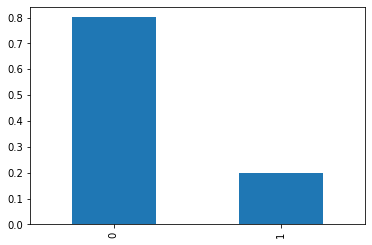

In [17]:
class_frequency = target_train.value_counts(normalize=True)
class_frequency.plot(kind='bar')

Наиболее частый ответ — 0.

In [18]:
# Формируем массив предсказанных значений 
target_pred_constant = pd.Series(0, index=target_valid.index)
print('accuracy:', accuracy_score(target_valid, target_pred_constant))

accuracy: 0.7885


**Вывод**

- Доли правильных ответов предсказанных с помощью модели решающего дерева и с помощью константной модели не сильно отличаются; 

- Из построенной гистограммы можно видеть, что присутвует дисбаланс классов;

- О дисбалансе классов нам также говорит и различие двух метрик accuracy и F1-меры. Accuracy не учитывает дисбаланс классов и показывает завышенную оценку.

Так как при дисбалансе классов метрика accuracy не точна, далее для оценки моделей используется F1-мера.

## Борьба с дисбалансом

- Предадим объектам редкого класса больший вес (class_weight='balanced'). 

In [19]:
model = RandomForestClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.5163297045101088


Значение F1-меры увеличилось, но не так как бы нам хотелось. 
- Увеличим выборку:

In [20]:
 # Разделяем обучающую выборку на отрицательные и положительные ответы
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]

target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

repeat = 10
# Создаём новую обучающую выборку
features_upsampled = pd.concat([features_zeros] + [features_ones]*repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones]*repeat)

# Перемешиваем данные
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

In [21]:
model = RandomForestClassifier(random_state=12345)

model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print('F1-мера модели случаного леса на валидационной выборке:', f1_score(target_valid, predicted_valid))

F1-мера модели случаного леса на валидационной выборке: 0.5797872340425531


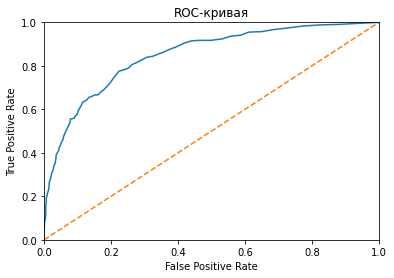

ROC_AUC модели случаного леса на валидационной выборке 0.8492199481014765


In [22]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = plot_roc_auc(target_valid,  probabilities_one_valid)
print("ROC_AUC модели случаного леса на валидационной выборке", auc_roc)

**Вывод**

Для борбы с дисбалансом класса были опробованны две технологии:

1) взвешивание классов 

2) увеличение выборки (upsampling)

При изменении веса классов F1-мера даже ухудшилась для модели случайного леса, при увеличении выборки F1-мера возросла.
Далее при подборе модели будем использовать второй способ борьбы с дисбалансом классов.

### Подбор модели

- Модель логистической регрессии:

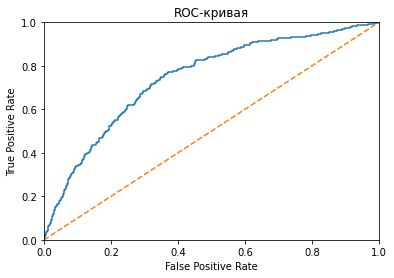

ROC-AUC: 0.7427335321127736
F1: 0.43009545199326216


In [23]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

# Вероятность класса
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = plot_roc_auc(target_valid, probabilities_one_valid)
f1 = f1_score(target_valid, predicted_valid)
print('ROC-AUC:', auc_roc)
print('F1:', f1)

- Модель решающего дерева:

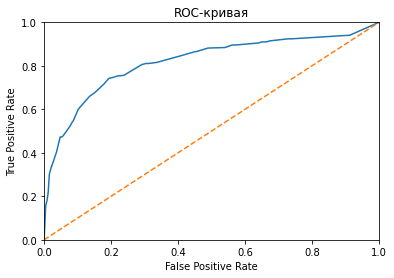

максимальная глубина решающего дерева: 7
F1-мера модели решающего дерева на валидационной выборке: 0.5453100158982511
ROC-AUC: 0.8180321135231483


In [24]:
best_result, max_depth, best_model_proba_one_valid = 0, 0, 0
for depth in range(1, 16):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)

    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    if best_result < result:
            best_result = result
            max_depth = depth
            best_model_proba_one_valid = probabilities_one_valid 
            
auc_roc = plot_roc_auc(target_valid,  best_model_proba_one_valid)

print("максимальная глубина решающего дерева:", max_depth)
print("F1-мера модели решающего дерева на валидационной выборке:", best_result)
print('ROC-AUC:', auc_roc)

- Модель случайного леса:

подбор гиперпараметров `max_depth` и `n_estimators`:

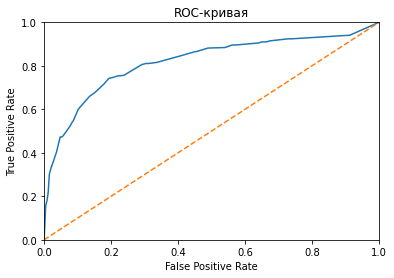

Максимальная глубина дерева: 15 
Количество деревьев: 60
F1-мера модели случайного леса на валидационной выборке: 0.5985915492957745
ROC-AUC: 0.8180321135231483


In [25]:
best_result, auc_roc = 0, 0
best_depth, best_est = 0, 0
best_model_probabilities_one_valid = 0

for est in range(10, 100, 10):
    for depth in range(1, 16):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        F1 = f1_score(target_valid, predicted_valid)

        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]

        if best_result < F1:
            best_result = F1
            best_depth = depth
            best_est = est
            best_model_probabilities_one_valid = probabilities_one_valid
            
auc_roc = plot_roc_auc(target_valid, best_model_proba_one_valid)
print('Максимальная глубина дерева:', best_depth, '\nКоличество деревьев:', best_est)
print("F1-мера модели случайного леса на валидационной выборке:", best_result)
print('ROC-AUC:', auc_roc)

**Вывод**

Были рассмотрены различные модели классификации, с различными гиперпараметрами.

Наиболее высокий показатель F1-меры на валидационной выборке у модели случайного леса с гиперпараметрами `n_estimators` = 30, `max_depth` = 14.

## Тестирование модели

Обучение модели случайного леса на тестовой выборке:

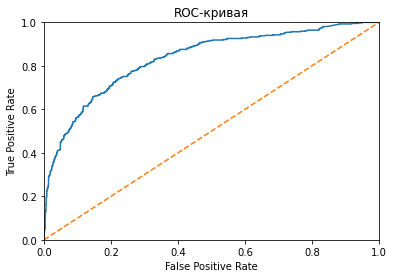

F1: 0.5869324473975636
ROC-AUC: 0.833815986063308


In [26]:
model = RandomForestClassifier(n_estimators=30, max_depth=14, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)

proba_test = model.predict_proba(features_test)
proba_one_test = proba_test[:, 1]

auc_roc = plot_roc_auc(target_test, proba_one_test)
F1 = f1_score(target_test, predicted_test)
print('F1:', F1)
print('ROC-AUC:', auc_roc)

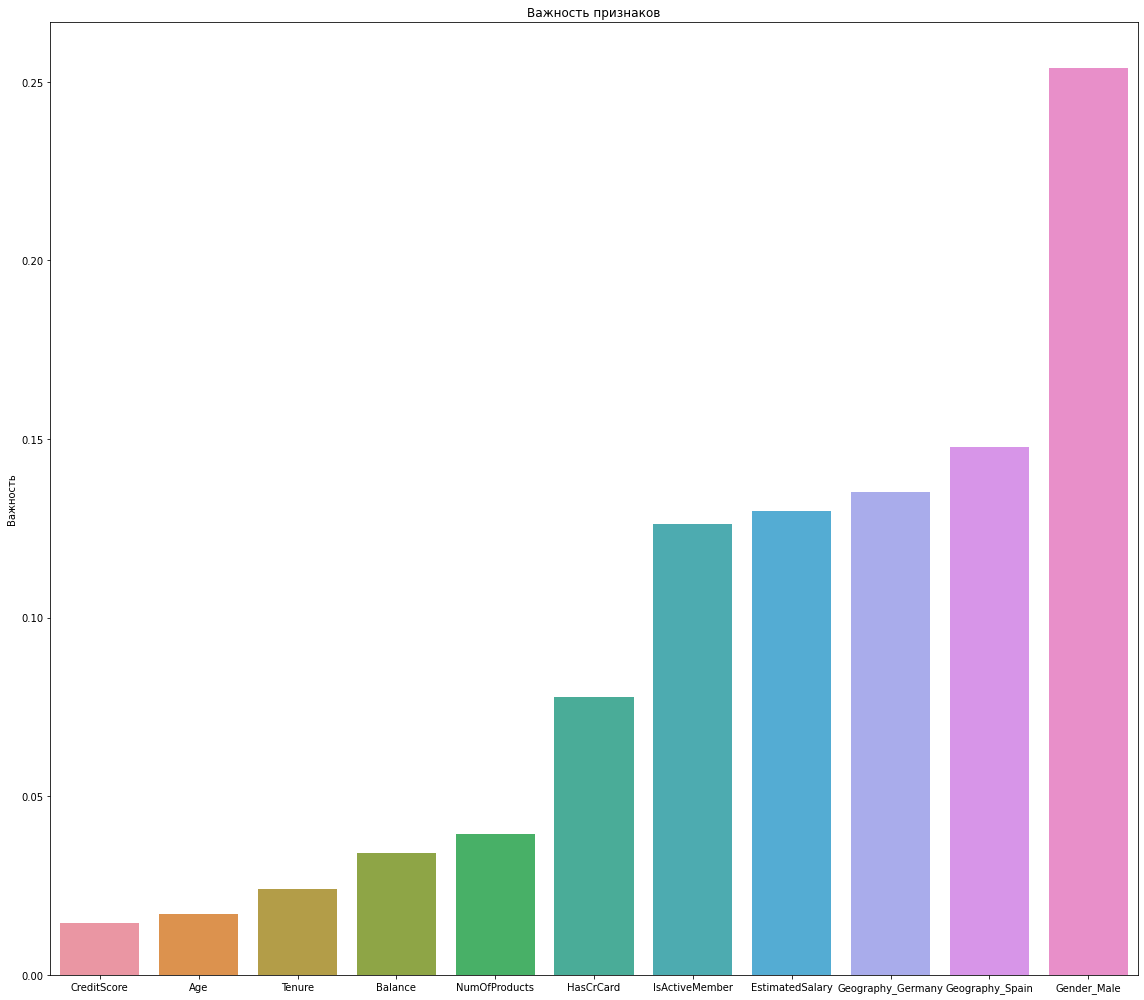

In [27]:
skl_imp = pd.Series(model.feature_importances_,
                         features_test.columns)

fig, ax = plt.subplots(figsize=(16,14))
sns.color_palette()
ax = sns.barplot(x=skl_imp.index, y=np.sort(skl_imp.values))
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

## Общий вывод

Для «Бета-Банка» проведено исследование в рамках которого необходимо было предсказать уход клиентов.

Для решения задачи классификации были построены различные модели предсказания, из которых наилучший результат по метрике F1 показала модель случайного леса с гиперпараметрами `n_estimators` = 30, `max_depth` = 14.